# lineart test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from flat import rgba, font, shape, strike, document
from IPython.display import Image
import dask

## First experiment

In [3]:
image_size = 100

In [4]:
# colors
canvas = rgba(254, 250, 219,255)
sand = rgba(254, 250, 219,50)
blue = rgba(33, 80, 98,255)
red = rgba(255, 0, 0,255)
# styles
background = shape().fill(blue).nostroke()
netstyle = shape().stroke(canvas).width(1)
sandstyle = shape().fill(sand).nostroke()
debug = shape().stroke(red).width(0.5)

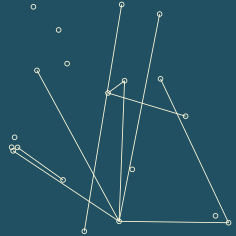

In [5]:
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))

nodes = np.random.rand(20,2)*image_size

for p in nodes:
    page.place(netstyle.circle(*p, 1))
for i in range(10):
    page.place(netstyle.line(*nodes[np.random.randint(len(nodes))],*nodes[np.random.randint(len(nodes))]))
    
# Display image
Image((page.image(kind='rgba', ppi=60).png())) 

## single line dither test

3D rotation about some normalised vector u

\begin{bmatrix}\cos \theta +u_{x}^{2}\left(1-\cos \theta \right)&u_{x}u_{y}\left(1-\cos \theta \right)-u_{z}\sin \theta &u_{x}u_{z}\left(1-\cos \theta \right)+u_{y}\sin \theta \\u_{y}u_{x}\left(1-\cos \theta \right)+u_{z}\sin \theta &\cos \theta +u_{y}^{2}\left(1-\cos \theta \right)&u_{y}u_{z}\left(1-\cos \theta \right)-u_{x}\sin \theta \\u_{z}u_{x}\left(1-\cos \theta \right)-u_{y}\sin \theta &u_{z}u_{y}\left(1-\cos \theta \right)+u_{x}\sin \theta &\cos \theta +u_{z}^{2}\left(1-\cos \theta \right)\end{bmatrix}

In [31]:
class SampleLine(object):
    def __init__(self, p1: np.array, p2: np.array):
        self.p1 = p1
        self.p2 = p2
        self.vector = p2-p1
    def sample(self, n, dither=0):
        r_sample = np.random.rand(n, 1)
        points = np.multiply(r_sample, self.vector)+self.p1
        if dither:
            z_values = points[:,2]
            jitter_scalar = np.multiply(dither,z_values)

            jitter = np.multiply((np.random.randn(n,2)*2-1),np.stack((jitter_scalar,jitter_scalar),axis=1))
            points = points + np.concatenate((jitter, np.zeros_like(z_values).reshape(-1,1)),axis=1)
        return points
    def rotate_xy(self,p0,theta):
        self.p1 = rotate_xy(self.p1,p0,theta)
        self.p2 = rotate_xy(self.p2,p0,theta)
        self.vector = self.p2-self.p1
        


def rotate(point, p0, normal, theta):
    ux, uy, uz = (normal/np.linalg.norm(normal))
    rot_mat = np.array([
        [np.cos(theta) + ux**2*(1-np.cos(theta)),    ux*uy*(1-np.cos(theta)) - uz*np.sin(theta),  ux*uz*(1-np.cos(theta)) + uy*np.sin(theta)],
        [uy*ux*(1-np.cos(theta)) + uz*np.sin(theta), np.cos(theta) + uy**2*(1-np.cos(theta)),     uy*uz*(1-np.cos(theta)) - ux*np.sin(theta)],
        [uz*ux*(1-np.cos(theta)) - uy*np.sin(theta), uz*uy*(1-np.cos(theta)) + ux*np.sin(theta),  np.cos(theta) + uz**2*(1-np.cos(theta))],
    ])
    
    p0_shifted = point-p0
    rotated = p0_shifted.dot(rot_mat)
    back_shifted = rotated+p0
    return back_shifted
    
def rotate_xy(point, p0, theta):
    back_shifted = rotate(point, p0, [0,0,1], theta)
    return back_shifted
    

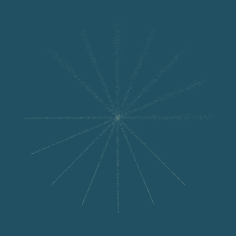

In [32]:
image_size = 100
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))


nodes = np.array([
    [10, 50,0], 
    [90, 50,100]
])
dither_line = SampleLine(*nodes)

rotation_point = np.array([50,50,0])
for i in range (7):
    theta = np.pi/8
    
    # page.place(netstyle.circle(*dither_line.p1[:2], 1))
    # page.place(netstyle.circle(*dither_line.p2[:2], 1))
    # page.place(debug.line(*dither_line.p1,*dither_line.p2))
    samples = dither_line.sample(1000, 0.004)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1))
    dither_line.rotate_xy(rotation_point, theta)
# Display image
Image((page.image(kind='rgba', ppi=60).png())) 

### Polygon test

In [8]:
class Octahedron:
    def __init__(self, center, radius):
        origin_nodes = np.array([
            [0,  radius, 0],
            [-radius, 0, 0],
            [0, 0, -radius],
            [ radius, 0, 0],
            [0, 0,  radius],
            [0, -radius, 0],
        ])
        self.nodes = origin_nodes + center
        self.edges = self.edges_from_nodes()
    def edges_from_nodes(self):
        edges = np.array([
            [self.nodes[0], self.nodes[1]],
            [self.nodes[0], self.nodes[2]],
            [self.nodes[0], self.nodes[3]],
            [self.nodes[0], self.nodes[4]],
            [self.nodes[5], self.nodes[1]],
            [self.nodes[5], self.nodes[2]],
            [self.nodes[5], self.nodes[3]],
            [self.nodes[5], self.nodes[4]],
            [self.nodes[1], self.nodes[2]],
            [self.nodes[2], self.nodes[3]],
            [self.nodes[3], self.nodes[4]],
            [self.nodes[4], self.nodes[1]],
            
        ])
        return edges
    def rotate(self, p0, normal, theta):
        self.nodes = rotate(self.nodes, p0, normal, theta)
        self.edges = self.edges_from_nodes()

        
class SampleOctahedron(Octahedron):
    def __init__(self, center, radius):
        super().__init__(center, radius)
        self.lines = [SampleLine(*e) for e in self.edges]
    def sample(self, n, dither):
        line_points = [line.sample(n, dither) for line in self.lines]
        points = np.concatenate(line_points)
        return points
    
    def rotate(self, p0, normal, theta):
        super().rotate( p0, normal, theta)
        self.lines = [SampleLine(*e) for e in self.edges]
        
        

#### Examination of rendering time for sampled polyhedra

In [82]:
%%time
image_size = 100
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))
o = SampleOctahedron(np.array([50,50,40]),40)

o.rotate([50,50,40], [1,1,1], np.pi*2/16)





CPU times: user 2.62 ms, sys: 3.95 ms, total: 6.57 ms
Wall time: 6.32 ms


In [83]:
%%time
# linear with number of samples
samples = o.sample(1000,0.01)

CPU times: user 2.6 ms, sys: 816 µs, total: 3.42 ms
Wall time: 2.48 ms


In [84]:
%%time
# slightly more than linear with number of samples
for p in samples:
    page.place(sandstyle.circle(*p[:2], 0.1)) 
# Display image

CPU times: user 35.5 ms, sys: 1.08 ms, total: 36.6 ms
Wall time: 35.9 ms


CPU times: user 1.39 s, sys: 2.65 ms, total: 1.39 s
Wall time: 1.39 s


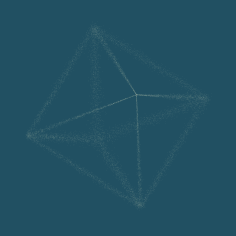

In [85]:
%%time
# linear with number of samples
Image((page.image(kind='rgba', ppi=60).png())) 

#### Dask delayed multiprocessing rendering of rotating image

In [27]:
@dask.delayed
def sample_octohedron(i):
    image_size = 100
    # page setup
    d = document(image_size, image_size, 'mm')
    page = d.addpage()
    page.place(background.rectangle(0,0,image_size,image_size))
    o = SampleOctahedron(np.array([50,50,40]),40)

    o.rotate([50,50,40], [1,1,1], np.pi*2/200*i)
    samples = o.sample(1000,0.03)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1)) 
    # Display image
    page.image(kind='rgba', ppi=60).png(f'outputs/{i:03d}.png')
    return i

samples = [sample_octohedron(i) for i in range(200)]


In [ ]:
%%time
dask.persist(*samples, scheduler='processes')

In [ ]:
%%time
dask.persist(*samples, scheduler='threads')

In [ ]:
%%time
dask.persist(*samples, scheduler='single-threaded')

### Random network